## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Data Handling

## Load Data

In [2]:
appl_df = pd.read_csv("data/application_record.csv")
credit_df = pd.read_csv("data/credit_record.csv")

df = pd.merge(appl_df, credit_df, how='inner', on='ID')
df_origin = df.copy()
df.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C


## Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777715 entries, 0 to 777714
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   777715 non-null  int64  
 1   CODE_GENDER          777715 non-null  object 
 2   FLAG_OWN_CAR         777715 non-null  object 
 3   FLAG_OWN_REALTY      777715 non-null  object 
 4   CNT_CHILDREN         777715 non-null  int64  
 5   AMT_INCOME_TOTAL     777715 non-null  float64
 6   NAME_INCOME_TYPE     777715 non-null  object 
 7   NAME_EDUCATION_TYPE  777715 non-null  object 
 8   NAME_FAMILY_STATUS   777715 non-null  object 
 9   NAME_HOUSING_TYPE    777715 non-null  object 
 10  DAYS_BIRTH           777715 non-null  int64  
 11  DAYS_EMPLOYED        777715 non-null  int64  
 12  FLAG_MOBIL           777715 non-null  int64  
 13  FLAG_WORK_PHONE      777715 non-null  int64  
 14  FLAG_PHONE           777715 non-null  int64  
 15  FLAG_EMAIL       

In [4]:
df.nunique()

ID                     36457
CODE_GENDER                2
FLAG_OWN_CAR               2
FLAG_OWN_REALTY            2
CNT_CHILDREN               9
AMT_INCOME_TOTAL         265
NAME_INCOME_TYPE           5
NAME_EDUCATION_TYPE        5
NAME_FAMILY_STATUS         5
NAME_HOUSING_TYPE          6
DAYS_BIRTH              7183
DAYS_EMPLOYED           3640
FLAG_MOBIL                 1
FLAG_WORK_PHONE            2
FLAG_PHONE                 2
FLAG_EMAIL                 2
OCCUPATION_TYPE           18
CNT_FAM_MEMBERS           10
MONTHS_BALANCE            61
STATUS                     8
dtype: int64

## Data Visualization

In [5]:
def plot_numeric_histograms(numeric_cols, n_cols=3):
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()

    i = -1
    for i, col in enumerate(numeric_cols):
        axes[i].hist(df[col], bins=24, color='skyblue', edgecolor='black')
        axes[i].set_title(col)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Кількість')

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


def plot_numeric_boxplots(numeric_cols, n_cols=3):
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()

    i = -1
    for i, col in enumerate(numeric_cols):
        sns.boxplot(y=df[col], ax=axes[i])
        axes[i].set_title(col)

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


def plot_categorical_bars(categorical_cols, n_cols=3):
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()

    i = -1
    for i, col in enumerate(categorical_cols):
        df[col].value_counts().plot(kind='bar', ax=axes[i], color='lightgreen', edgecolor='black')
        axes[i].set_title(col)
        axes[i].set_ylabel('Кількість')
        axes[i].set_xlabel(col)

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
numeric_features = df.select_dtypes(include=['int64', 'float64'])
categorical_features = df.select_dtypes(include=['object', 'category'])

### Numeric Features

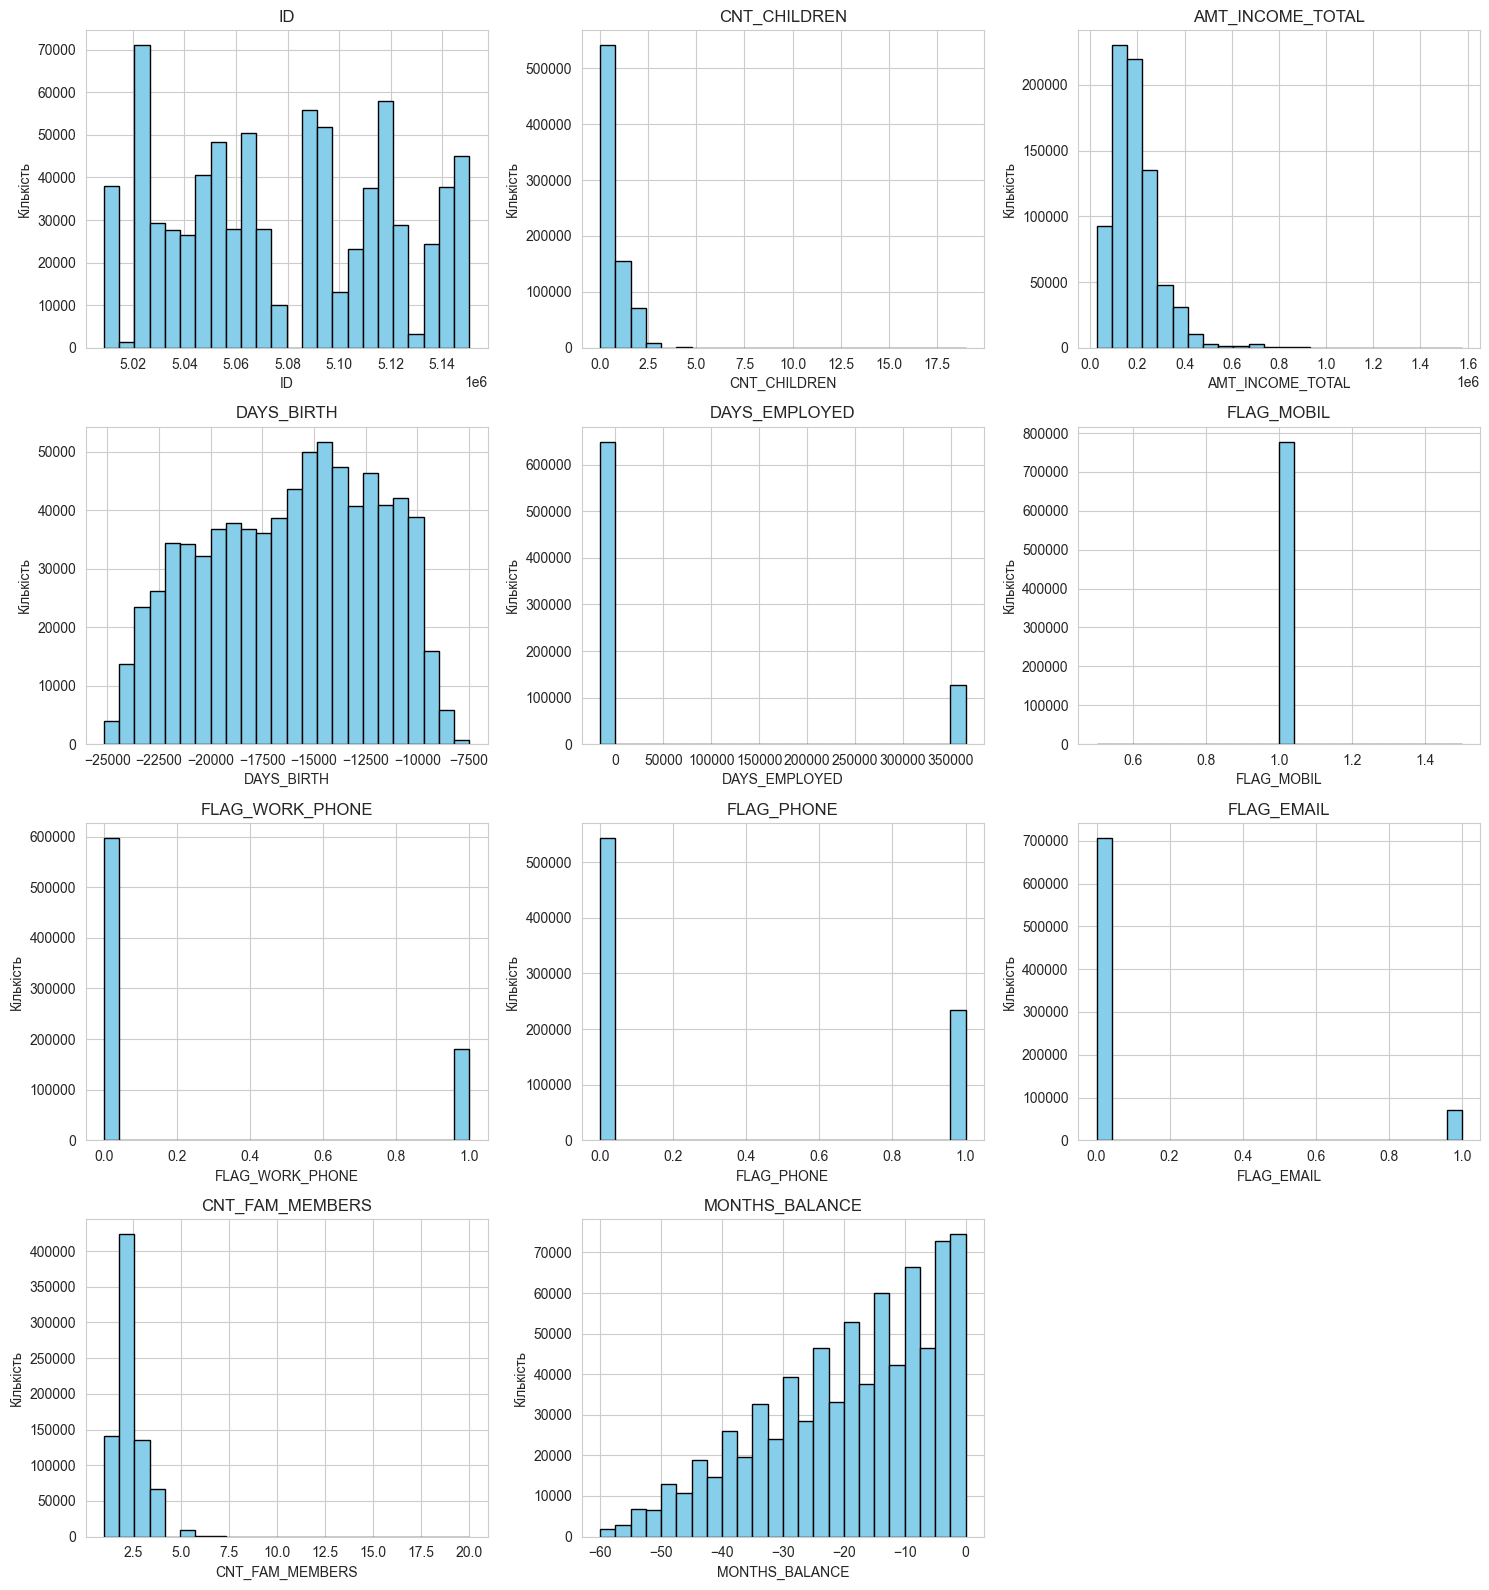

In [7]:
plot_numeric_histograms(numeric_features.columns)

### Category Features

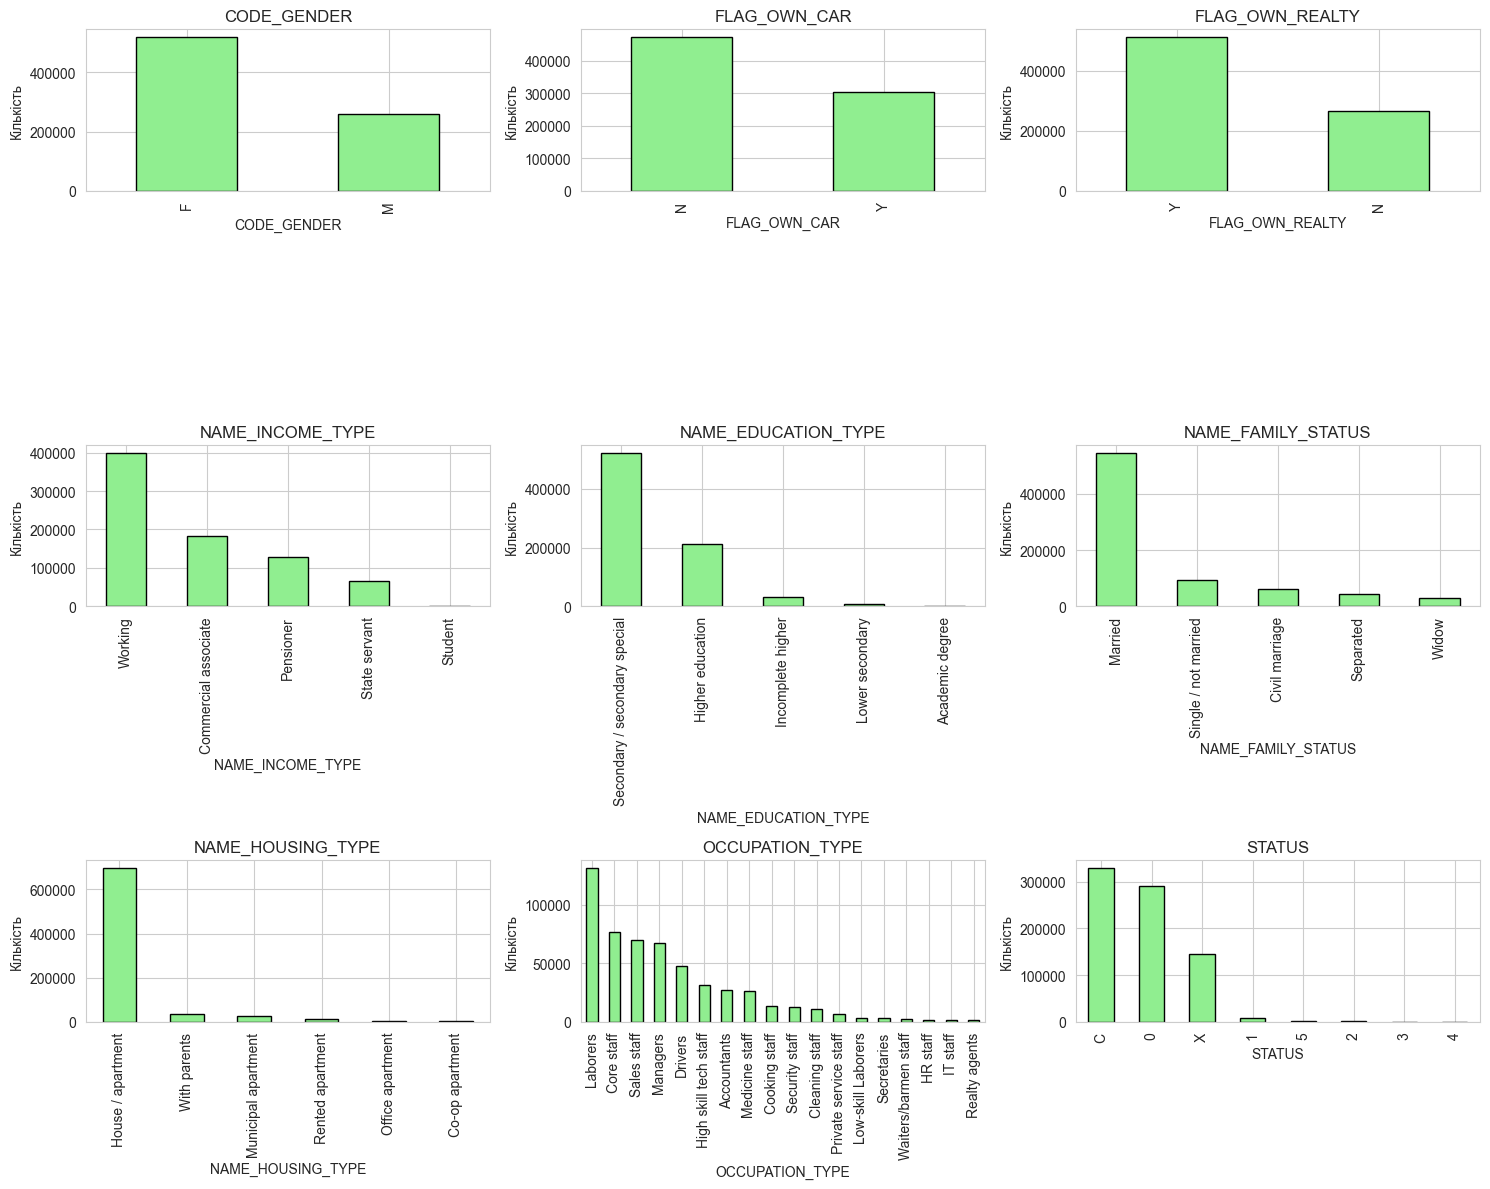

In [8]:
plot_categorical_bars(categorical_features.columns)

## Data Preprocessing

### Target Class Balancing

In [9]:
df['STATUS'].value_counts()

STATUS
C    329536
0    290654
X    145950
1      8747
5      1527
2       801
3       286
4       214
Name: count, dtype: int64

In [10]:
mapping = {
    'X': 'Early',
    'C': 'OnTime',
    '0': 'Late',
    '1': 'Late',
    '2': 'Late',
    '3': 'Late',
    '4': 'Late',
    '5': 'Late'
}

df['STATUS'] = df['STATUS'].map(mapping)
df['STATUS'].value_counts()

STATUS
OnTime    329536
Late      302229
Early     145950
Name: count, dtype: int64

### Dropping Non-informative Features

In [11]:
df.drop(['ID', 'FLAG_MOBIL', 'MONTHS_BALANCE'], axis=1, inplace=True)

numeric_features = df.select_dtypes(include=['int64', 'float64'])
categorical_features = df.select_dtypes(include=['object', 'category'])

### Numerical Feature Preprocessing

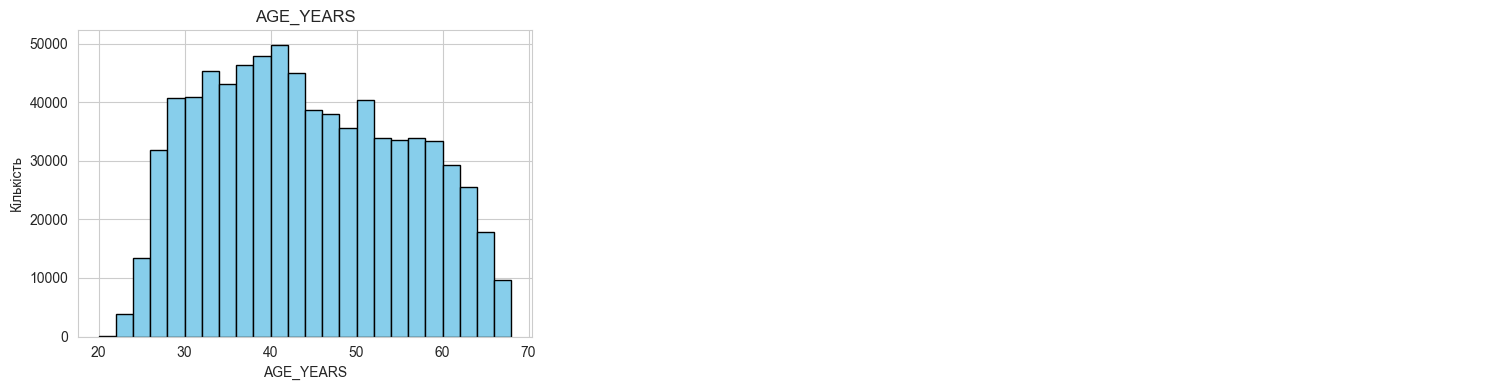

In [12]:
df['AGE_YEARS'] = np.floor(-df['DAYS_BIRTH'] / 365).astype(int)
df.drop(columns=['DAYS_BIRTH'], inplace=True)

plot_numeric_histograms(['AGE_YEARS'])

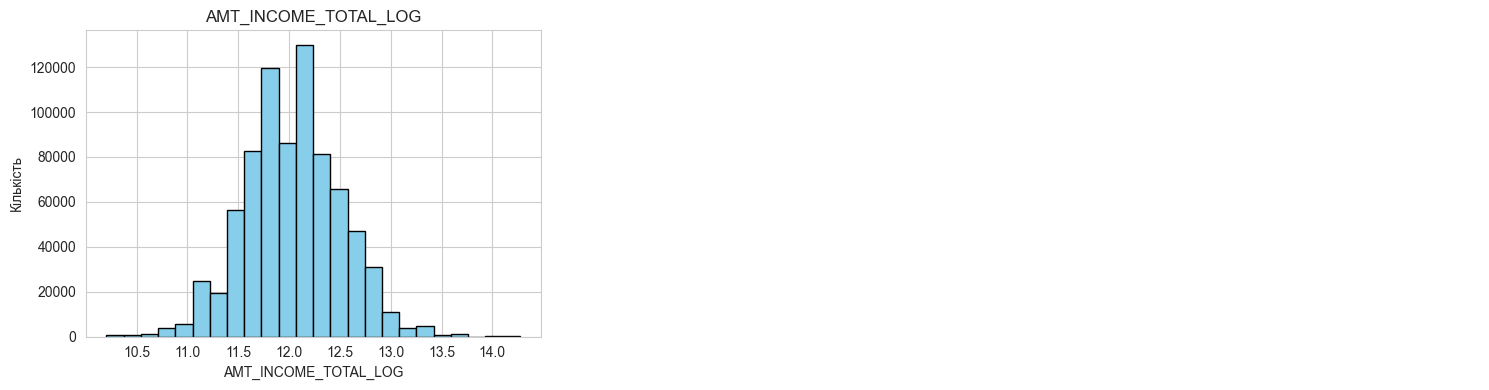

In [13]:
df['AMT_INCOME_TOTAL_LOG'] = np.log1p(df['AMT_INCOME_TOTAL'])
df.drop(columns=['AMT_INCOME_TOTAL'], inplace=True)

plot_numeric_histograms(['AMT_INCOME_TOTAL_LOG'])

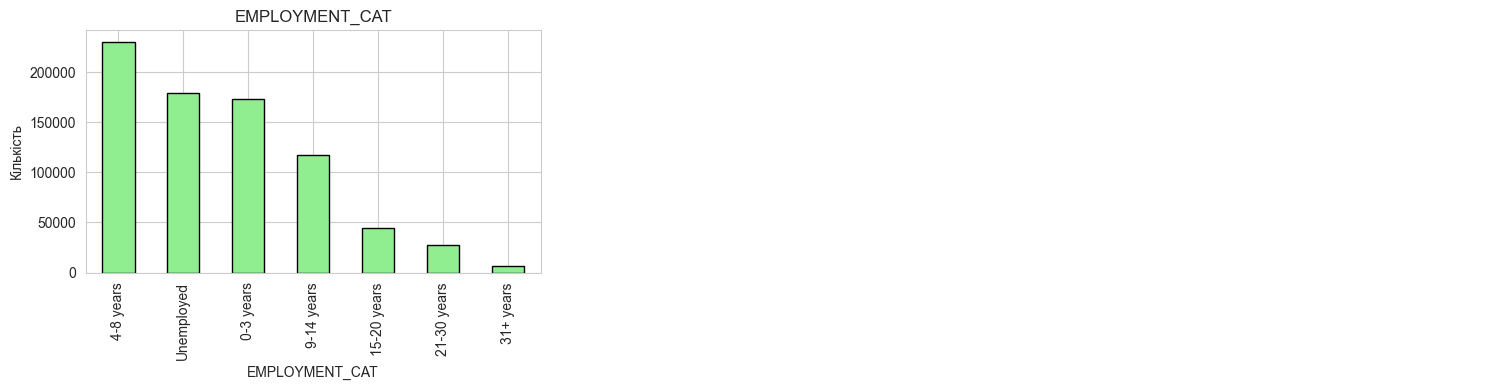

In [14]:
df['YEARS_EMPLOYED'] = np.floor(-df['DAYS_EMPLOYED'] / 365).astype(int)
df.drop(columns=['DAYS_EMPLOYED'], inplace=True)

bins = [-np.inf, 0, 3, 8, 14, 20, 30, np.inf]
labels = ['Unemployed', '0-3 years', '4-8 years', '9-14 years',
          '15-20 years', '21-30 years', '31+ years']
df['EMPLOYMENT_CAT'] = pd.cut(df['YEARS_EMPLOYED'], bins=bins, labels=labels)
plot_categorical_bars(['EMPLOYMENT_CAT'])

df.drop(columns=['YEARS_EMPLOYED'], inplace=True)

### Category Features Encoding

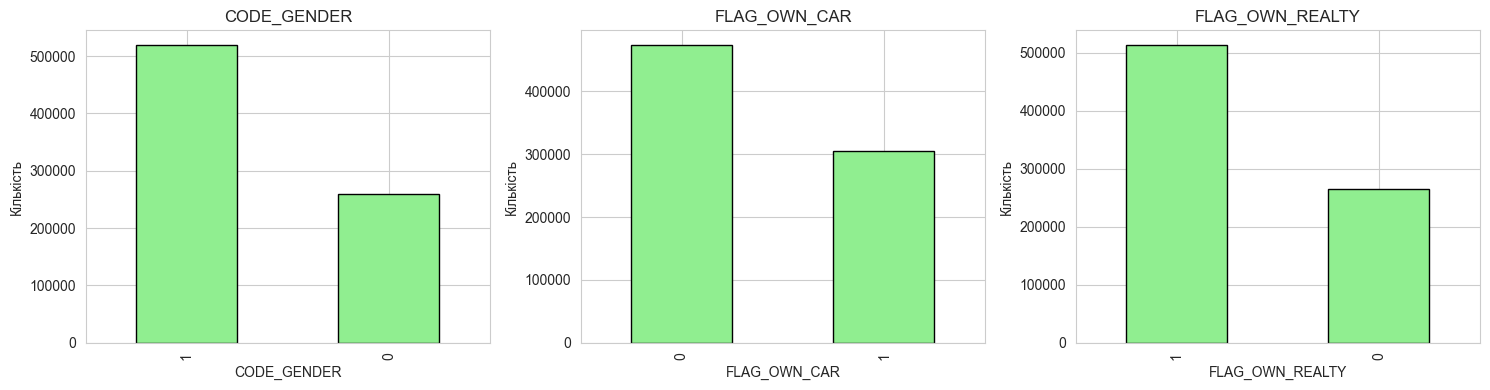

In [15]:
df['CODE_GENDER'] = df['CODE_GENDER'].map({'M': 0, 'F': 1})
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].map({'N': 0, 'Y': 1})
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].map({'N': 0, 'Y': 1})

plot_categorical_bars(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY'])

In [16]:
education_cats = [['Lower secondary', 'Secondary / secondary special', 'Incomplete higher',
                  'Higher education', 'Academic degree']]

employment_cats = [['Unemployed', '0-3 years', '4-8 years', '9-14 years', '15-20 years',
                    '21-30 years', '31+ years']]

status_cats = [['Early', 'OnTime', 'Late',]]

encoder = OrdinalEncoder(categories=education_cats)
df['EDUCATION_ENCODED'] = encoder.fit_transform(df[['NAME_EDUCATION_TYPE']])

encoder = OrdinalEncoder(categories=employment_cats)
df['EMPLOYMENT_ENCODED'] = encoder.fit_transform(df[['EMPLOYMENT_CAT']])

encoder = OrdinalEncoder(categories=status_cats)
df['STATUS_ENCODED'] = encoder.fit_transform(df[['STATUS']])

df.drop(['NAME_EDUCATION_TYPE', 'EMPLOYMENT_CAT', 'STATUS'], axis=1, inplace=True)

In [17]:
df = pd.get_dummies(
    df,
    columns=['NAME_HOUSING_TYPE', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE'],
    prefix=['HOUSING', 'FAMILY', 'INCOME']
)

### Missing Data Imputation

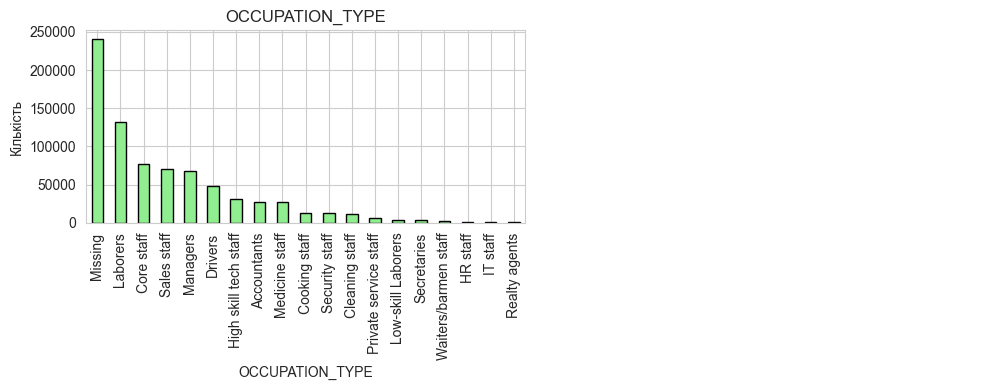

In [18]:
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna('Missing')
plot_categorical_bars(['OCCUPATION_TYPE'], n_cols=2)

In [19]:
encoder = ce.CountEncoder(normalize=False)
df['OCCUPATION_TYPE'] = encoder.fit_transform(df['OCCUPATION_TYPE'])

df.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'AGE_YEARS', 'AMT_INCOME_TOTAL_LOG',
       'EDUCATION_ENCODED', 'EMPLOYMENT_ENCODED', 'STATUS_ENCODED',
       'HOUSING_Co-op apartment', 'HOUSING_House / apartment',
       'HOUSING_Municipal apartment', 'HOUSING_Office apartment',
       'HOUSING_Rented apartment', 'HOUSING_With parents',
       'FAMILY_Civil marriage', 'FAMILY_Married', 'FAMILY_Separated',
       'FAMILY_Single / not married', 'FAMILY_Widow',
       'INCOME_Commercial associate', 'INCOME_Pensioner',
       'INCOME_State servant', 'INCOME_Student', 'INCOME_Working'],
      dtype='object')

## Feature Engineering

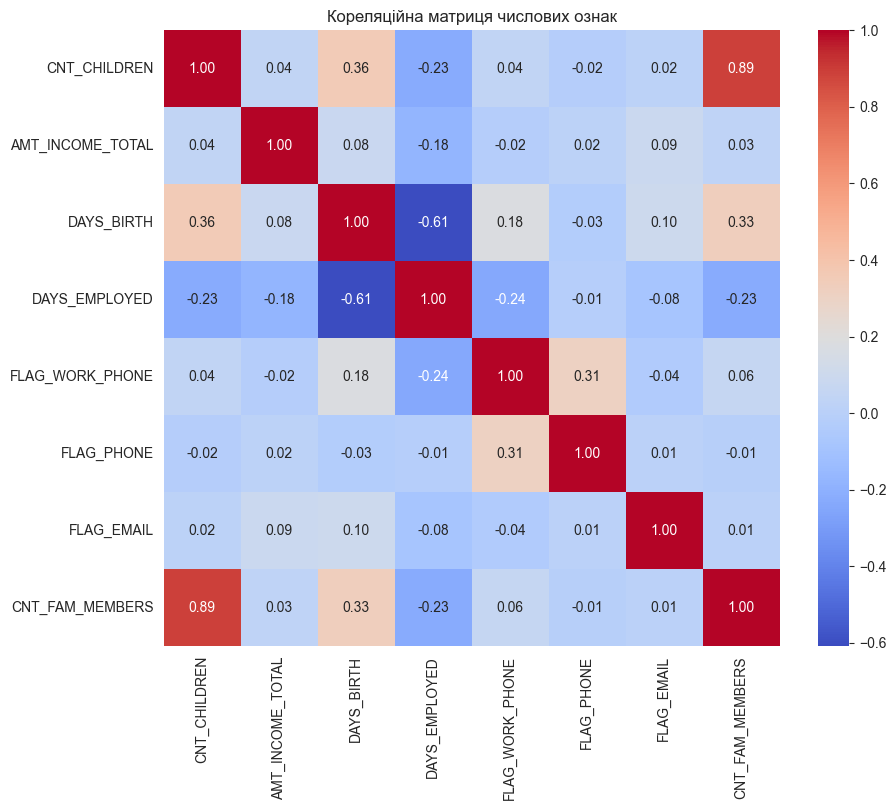

In [20]:
corr_matrix = numeric_features.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Кореляційна матриця числових ознак")
plt.show()

In [21]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

categorical_cols = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL','OCCUPATION_TYPE', 'EDUCATION_ENCODED', 'EMPLOYMENT_ENCODED', 'HOUSING_Co-op apartment', 'HOUSING_House / apartment', 'HOUSING_Municipal apartment', 'HOUSING_Office apartment', 'HOUSING_Rented apartment', 'HOUSING_With parents', 'FAMILY_Civil marriage', 'FAMILY_Married', 'FAMILY_Separated', 'FAMILY_Single / not married', 'FAMILY_Widow', 'INCOME_Commercial associate', 'INCOME_Pensioner', 'INCOME_State servant', 'INCOME_Student', 'INCOME_Working']

y = df['STATUS_ENCODED']

X_cat = df[categorical_cols]

chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(X_cat, y)

chi2_scores = pd.DataFrame({
    'Feature': categorical_cols,
    'Chi2 Score': chi2_selector.scores_
}).sort_values(by='Chi2 Score', ascending=False)

chi2_scores

,Feature,Chi2 Score
6,OCCUPATION_TYPE,6.087481e+06
9,HOUSING_Co-op apartment,2.790318e+02
4,FLAG_PHONE,2.747283e+02
18,FAMILY_Single / not married,1.956796e+02
7,EDUCATION_ENCODED,1.816251e+02
3,FLAG_WORK_PHONE,1.396849e+02
5,FLAG_EMAIL,1.051756e+02
12,HOUSING_Office apartment,7.487506e+01
19,FAMILY_Widow,7.324564e+01
1,FLAG_OWN_CAR,6.825325e+01


In [22]:
from sklearn.feature_selection import f_classif

numeric_cols = ['CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'AGE_YEARS', 'AMT_INCOME_TOTAL_LOG']

X_num = df[numeric_cols]

anova_selector = SelectKBest(f_classif, k='all')
anova_selector.fit(X_num, y)

anova_scores = pd.DataFrame({
    'Feature': numeric_cols,
    'ANOVA F-score': anova_selector.scores_
}).sort_values(by='ANOVA F-score', ascending=False)

anova_scores

,Feature,ANOVA F-score
3,AMT_INCOME_TOTAL_LOG,493.110444
2,AGE_YEARS,57.778820
0,CNT_CHILDREN,8.306495
1,CNT_FAM_MEMBERS,8.142309


In [23]:
df.drop(columns=['CNT_FAM_MEMBERS'], inplace=True)

## Train-Test Split

In [24]:
X = df.drop(columns=['STATUS_ENCODED'])
y = df['STATUS_ENCODED']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## SMOTE

In [25]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

/Users/artemsomar/Desktop/Machine Learning/university/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


AttributeError: 'Series' object has no attribute 'value_count'

In [26]:
y_smote.value_counts()

STATUS_ENCODED
2.0    263629
1.0    263629
0.0    263629
Name: count, dtype: int64

# Modeling

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)

loss, acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {acc:.4f}")

/Users/artemsomar/Desktop/Machine Learning/university/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
15555/15555 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - accuracy: 0.4149 - loss: 305.1532 - val_accuracy: 0.4253 - val_loss: 1.0443
Epoch 2/10
15555/15555 ━━━━━━━━━━━━━━━━━━━━ 15s 986us/step - accuracy: 0.4220 - loss: 1.0517 - val_accuracy: 0.4253 - val_loss: 1.0444
Epoch 3/10
15555/15555 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.4237 - loss: 1.0501 - val_accuracy: 0.4253 - val_loss: 1.0442
Epoch 4/10
15555/15555 ━━━━━━━━━━━━━━━━━━━━ 15s 955us/step - accuracy: 0.4235 - loss: 1.0467 - val_accuracy: 0.4253 - val_loss: 1.0442
Epoch 5/10
15133/15555 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.4233 - loss: 1.0482

KeyboardInterrupt: 